In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from PIL import Image
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [4]:
path = r"C:\Users\Tony\Desktop\Computer & Data Science\Summer 2\Traning\Final Project\data\UTKFace"
files = os.listdir(path)
print('total samples :',len(files))

total samples : 23708


In [5]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []
ages = []

for file in files:
    image_path = os.path.join(path, file)
    temp = file.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    
    if age >80:
        age_labels.append(4)
    elif age > 60:      
        age_labels.append(3)
    elif age > 40:
        age_labels.append(2)
    elif age > 20:
        age_labels.append(1)
    else:
        age_labels.append(0)
    
    ages.append(age)
    image_paths.append(image_path)
    gender_labels.append(gender)

In [6]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   23708 non-null  object
 1   age     23708 non-null  int64 
 2   gender  23708 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 555.8+ KB


In [7]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}
age_dict = {0:'0-20', 1:'21-40', 2:'41-60', 3:'61-80', 4:'80+'}

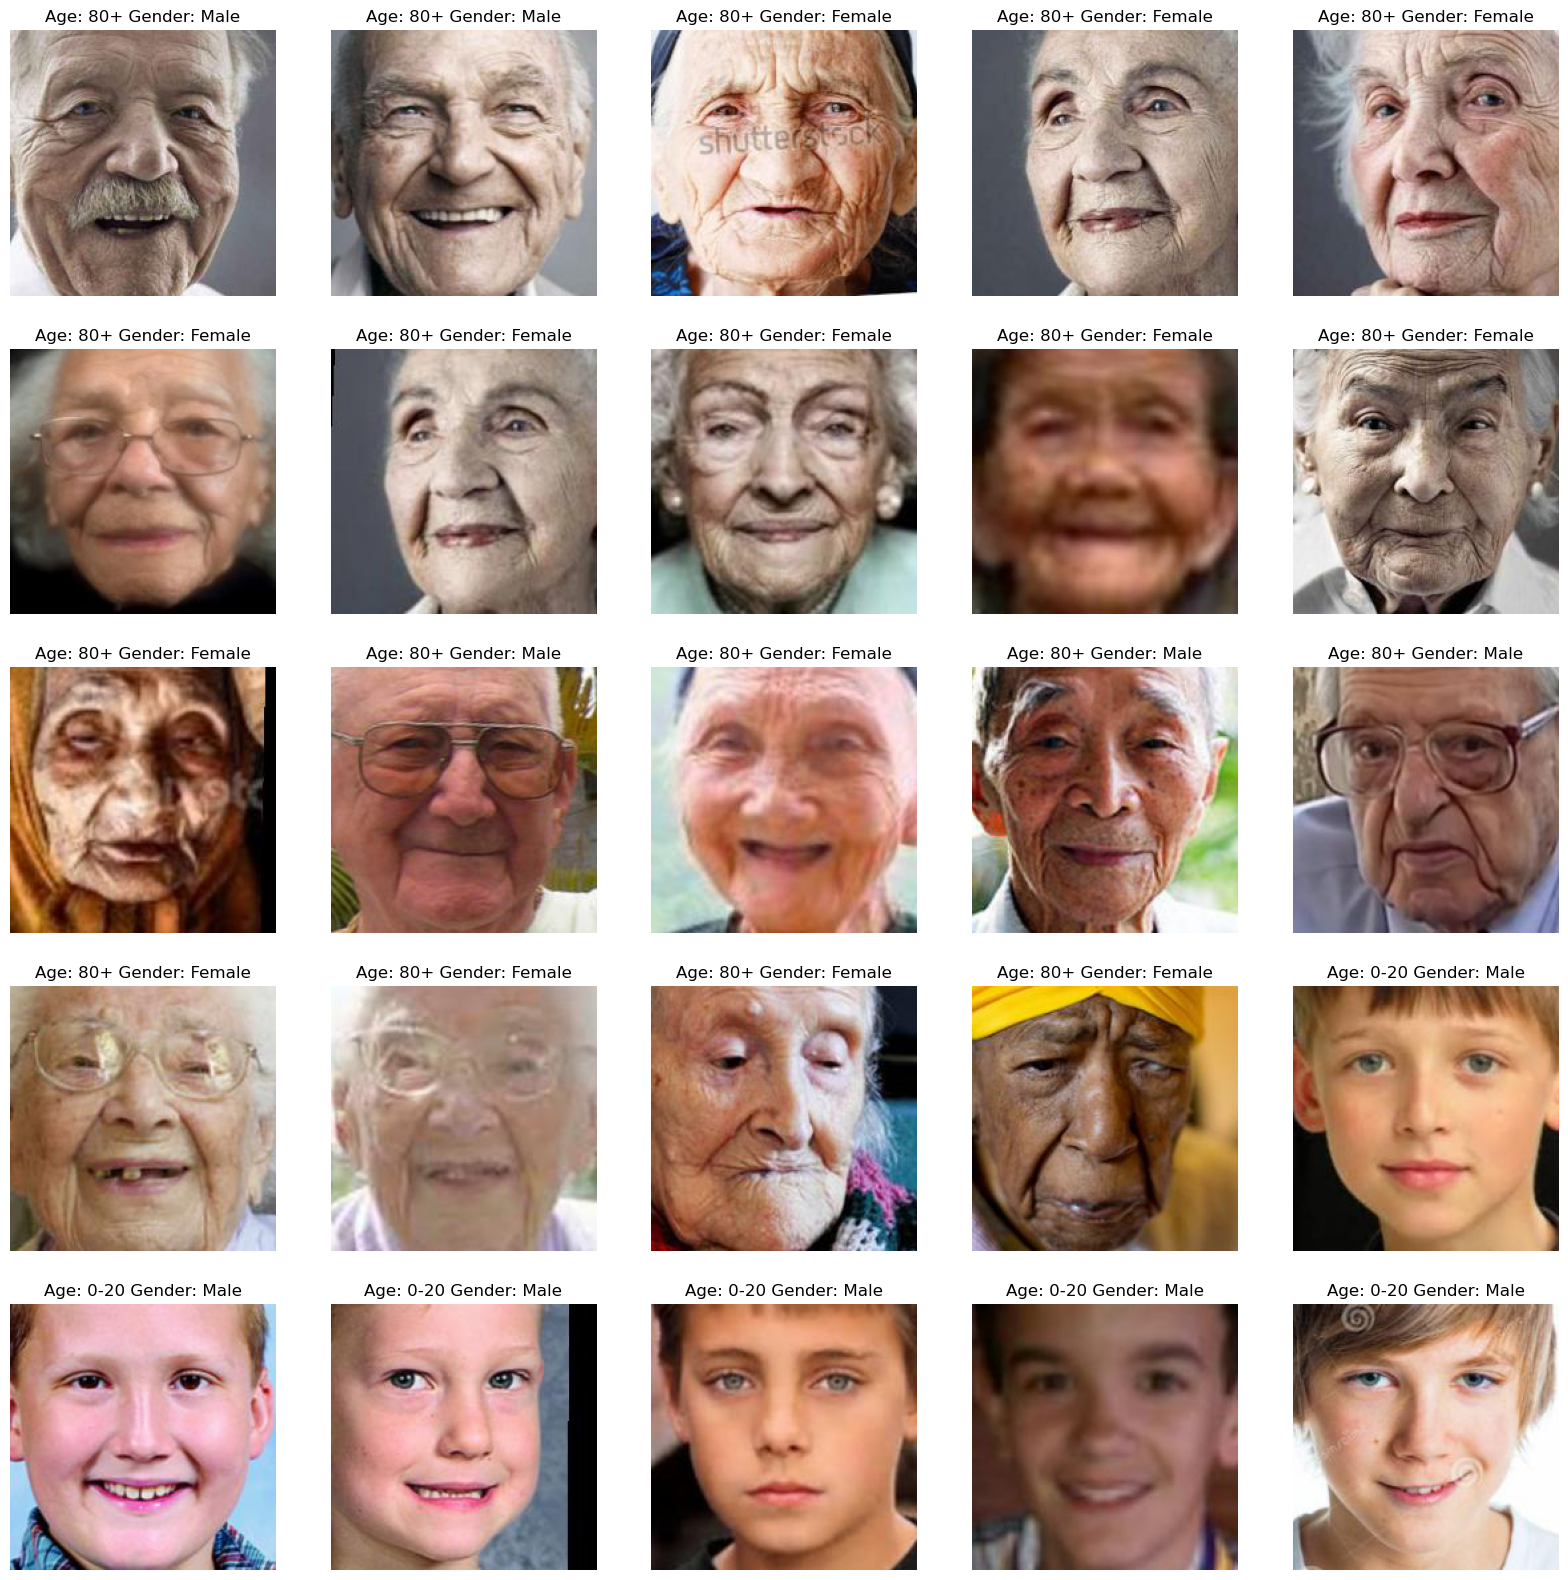

In [8]:
# to display grid of images
plt.figure(figsize=(20, 20))
photos = df.iloc[0:25]

for index, photo, age, gender in photos.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(photo)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age_dict[age]} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Exploratory Data Analysis

C:\Users\Tony\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

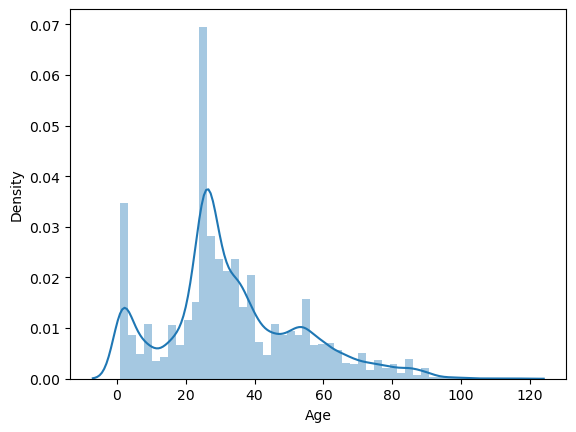

In [9]:
sns.distplot(ages)
plt.xlabel("Age")
plt.ylabel("Density")

C:\Users\Tony\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

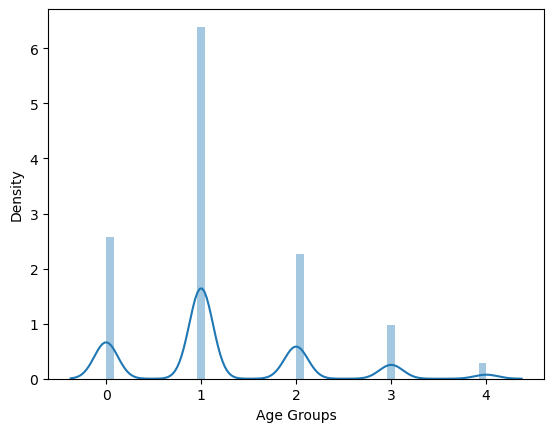

In [10]:
sns.distplot(df['age'])
plt.xlabel("Age Groups")
plt.ylabel("Density")

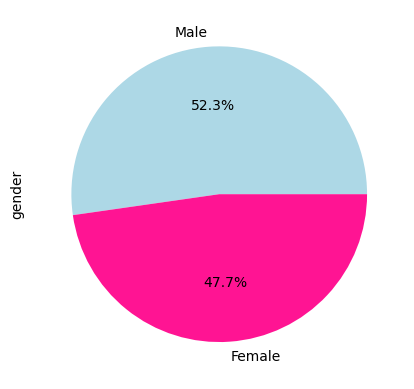

In [11]:
df['gender'].value_counts().plot(kind='pie',autopct="%.1f%%", labels=["Male", "Female"], colors=["#ADD8E6", "#FF1493"]);

## Feature Extraction

In [12]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features


In [13]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

C:\Users\Tony\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
C:\Users\Tony\AppData\Local\Temp\ipykernel_2532\4169889205.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((128, 128), Image.ANTIALIAS)


In [14]:
X.shape

(23708, 128, 128, 1)

In [15]:
# normalize the images
X = X/255.0

In [16]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [18]:
# Splitting dataset into 70% Training and 30% Testing Data
X_train, X_test, y_gender_train, y_gender_test, y_age_train, y_age_test = train_test_split(
    X, y_gender, y_age, test_size=0.1, random_state=42)

print('Train images shape {}'.format(X_train.shape))
print('Test images shape {}'.format(X_test.shape))

Train images shape (21337, 128, 128, 1)
Test images shape (2371, 128, 128, 1)


In [19]:
input_shape = (128, 128, 1)
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [20]:
# train model
history = model.fit(x=X_train, y=[y_gender_train, y_age_train], batch_size=32, epochs=5, validation_split=0.2)

Epoch 1/5
534/534 [==============================] - 421s 775ms/step - loss: 1.0781 - gender_out_loss: 0.4881 - age_out_loss: 0.5901 - gender_out_accuracy: 0.7496 - age_out_accuracy: 0.5652 - val_loss: 0.8892 - val_gender_out_loss: 0.3696 - val_age_out_loss: 0.5196 - val_gender_out_accuracy: 0.8376 - val_age_out_accuracy: 0.5989
Epoch 2/5
534/534 [==============================] - 411s 770ms/step - loss: 0.7701 - gender_out_loss: 0.3201 - age_out_loss: 0.4500 - gender_out_accuracy: 0.8562 - age_out_accuracy: 0.6186 - val_loss: 0.7347 - val_gender_out_loss: 0.3240 - val_age_out_loss: 0.4107 - val_gender_out_accuracy: 0.8618 - val_age_out_accuracy: 0.6261
Epoch 3/5
534/534 [==============================] - 498s 932ms/step - loss: 0.6726 - gender_out_loss: 0.2730 - age_out_loss: 0.3996 - gender_out_accuracy: 0.8787 - age_out_accuracy: 0.6331 - val_loss: 0.7577 - val_gender_out_loss: 0.2812 - val_age_out_loss: 0.4765 - val_gender_out_accuracy: 0.8810 - val_age_out_accuracy: 0.6010
Epoch 4

In [22]:
#Evaluate the model on the test data
test_loss, test_gender_loss, test_age_loss, test_gender_accuracy, test_age_accuracy = model.evaluate(
    X_test, [y_gender_test, y_age_test], verbose=2)

print(f"Test Gender accuracy: {test_gender_accuracy:.4f}")
print(f"Test Age accuracy: {test_age_accuracy:.4f}")



75/75 - 11s - loss: 0.6639 - gender_out_loss: 0.2753 - age_out_loss: 0.3886 - gender_out_accuracy: 0.8899 - age_out_accuracy: 0.6487 - 11s/epoch - 153ms/step
Test Gender accuracy: 0.8899
Test Age accuracy: 0.6487


Real Gender: Female Real Age: 100
1/1 [==============================] - 0s 278ms/step
Predicted Gender: Female Predicted Age: 80+


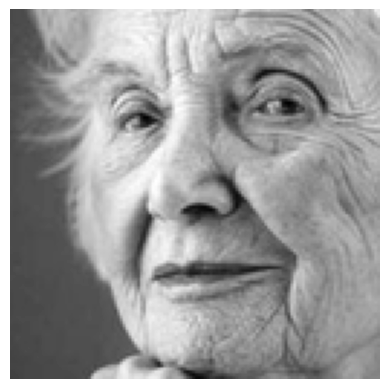

In [23]:
image_index = 4
print("Real Gender:", gender_dict[y_gender[image_index]], "Real Age:", ages[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", age_dict[pred_age])
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Real Gender: Male Real Age: 21
1/1 [==============================] - 0s 49ms/step
Predicted Gender: Male Predicted Age: 21-40


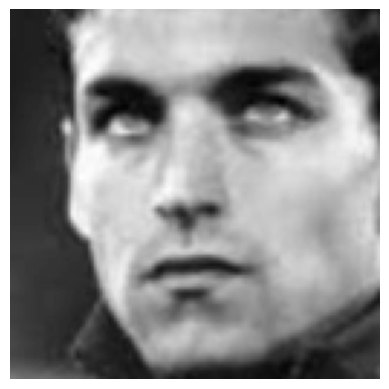

In [120]:
image_index = 3000
print("Real Gender:", gender_dict[y_gender[image_index]], "Real Age:", ages[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", age_dict[pred_age])
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Real Gender: Female Real Age: 29
1/1 [==============================] - 0s 42ms/step
Predicted Gender: Female Predicted Age: 21-40


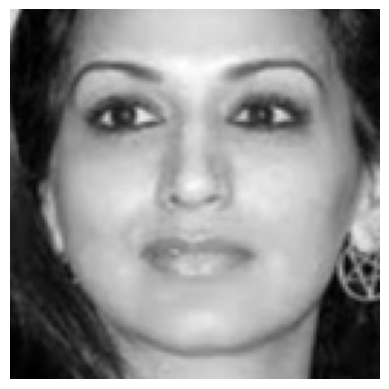

In [121]:
image_index = 10000
print("Real Gender:", gender_dict[y_gender[image_index]], "Real Age:", ages[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", age_dict[pred_age])
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');